In [29]:
def downsample_image(image, n, final_size):
    """Downsamples a 1D or 2D NumPy array by combining n^2 pixels into 1 pixel

    Args:
        image: A 1D or 2D NumPy array representing the image.

    Returns:
        A 2D NumPy array representing the downsampled image.
    """
    # Reshape the image into a 3D array
    image = image.reshape(final_size, n, final_size, n)

    # Average the pixels in each block
    return image.sum(axis=(1, 3))

In [ ]:
%%time
import multiprocessing as mp
import itertools
import numpy as np
from astropy.io import fits
import h5py
target_pixel = 455 # The pixel number of the target image in the x-direction and y-direction
# Calculate the psf scale in arcsecs per pixel
rad_to_arcsecond = 206264.806247
visual_range = 72 # in lambda/D

# Example .fits file has unit W/m^2/pixel
# vF_v(W/m^2/pixel) to F_v(Jy/arcsec^2)
light_speed = 299792458 # m/s
jy=10**26 # The conversion factor from W / m^2 / sr / Hz to Jy

super_sample = 3
wavelengths_nm = [575,660,730,825] # meter
Ds = {"3m":3,"6m":6,"8m":8} # aperture size in meter
incs = [0, 15, 30, 45, 60, 75, 85, 90]

pre_img_number = len(wavelengths_nm)*len(Ds)*len(incs)
pre_imgs = np.empty([pre_img_number,target_pixel,target_pixel], dtype=np.float64)
psf_scales = np.empty(pre_img_number, dtype=np.float64)
fits_names = np.empty(pre_img_number, dtype=object)
img_wavelengths_nm = np.empty(pre_img_number, dtype=np.uint16)
telescope_sizes = np.empty(pre_img_number, dtype=np.float64)
for i, (wavelength_nm, D_name, inc) in zip(range(pre_img_number), itertools.product(wavelengths_nm, Ds, incs)):
    #print(D, wavelength)
    D = Ds[D_name]
    wavelength = wavelength_nm*1e-9
    psf_scale = wavelength/D*rad_to_arcsecond*visual_range/target_pixel # arcsec per pixel
    fits_name = str(wavelength_nm)+D_name+str(inc)
    with fits.open("../Toy_Coronagraph/tests/mcfost/"+fits_name+".fits") as fits_read:
        super_origin = fits_read[0].data[5,0] # vF_v(W/m^2/pixel)
    origin = downsample_image(super_origin, super_sample, target_pixel)

    F_transfer = jy*wavelength/light_speed/psf_scale**2
    F_v = origin*F_transfer # F_v(Jy/arcsec^2)
    pre_imgs[i] = F_v.astype(np.float64)
    psf_scales[i] = psf_scale
    fits_names[i] = fits_name
    img_wavelengths_nm[i] = wavelength_nm
    telescope_sizes[i] = D

CPU times: user 1.14 s, sys: 89.3 ms, total: 1.23 s
Wall time: 1.23 s


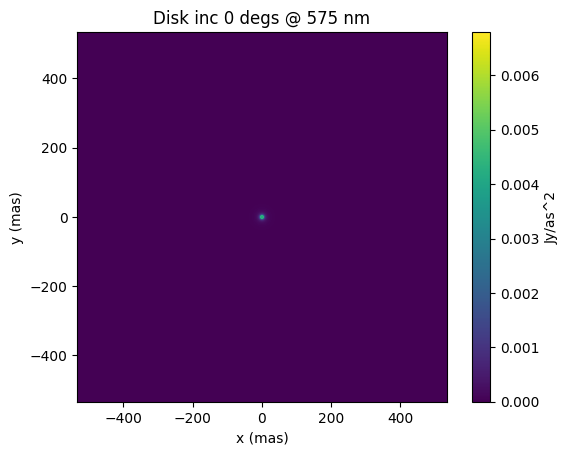

In [3]:
import matplotlib.pyplot as plt
i = 16
extent = np.array([-1, 1, -1, 1])*target_pixel/2*psf_scales[i]*1000
#np.unique(psf_scales)
plt.imshow(pre_imgs[i], extent=extent, cmap='viridis', origin='lower')
plt.colorbar(label='Jy/as^2')
plt.title(f'Disk inc {incs[i%8]} degs @ {int(img_wavelengths_nm[i])} nm')
plt.xlabel('Angular Separation (mas)')
plt.xlabel('x (mas)')
plt.ylabel('y (mas)')
plt.show()

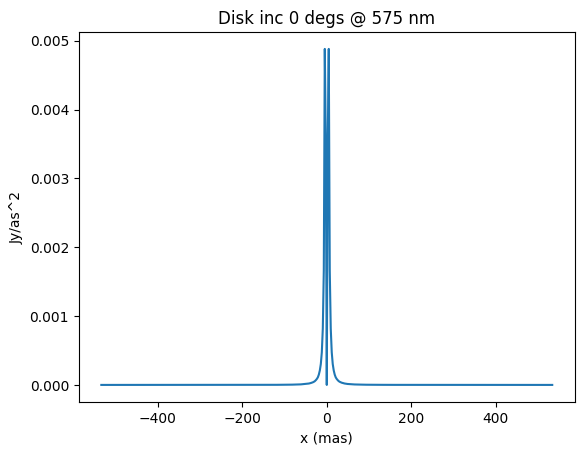

In [4]:
# plot the brightness of the disk at x axis
plt.plot(np.linspace(extent[0],extent[1],target_pixel), pre_imgs[i][target_pixel//2])
plt.xlabel('x (mas)')
plt.ylabel('Jy/as^2')
plt.title(f'Disk inc {incs[i%8]} degs @ {int(img_wavelengths_nm[i])} nm')
plt.show()

In [1]:
def print_line(file_name, line_number):
    """Changes the line at the given line number in the given file to the given new text."""
    with open(file_name, "r") as file:
        lines = file.readlines()
    print(lines[line_number - 1])
def change_line(file_name, line_number, new_text):
    """Changes the line at the given line number in the given file to the given new text."""
    with open(file_name, "r") as file:
        lines = file.readlines()
        
    lines[line_number - 1] = new_text
    with open(file_name, "w") as file:
        file.writelines(lines)

In [2]:
%%time
import numpy as np
import pandas as pd
import sys
from os import path
from importlib import reload

import os
import itertools
import tqdm

def generate_system(img_number, inc, pixscale):
    print(pixscale)
    change_line("src/Settings.py", 7,"    pixscale:     float = "+str(pixscale)+"/2 \n")
    from src import read_solarsystem
    from src import generate_scene
    from src import Settings
    read_solarsystem = reload(read_solarsystem)
    generate_scene = reload(generate_scene)
    Settings = reload(Settings)

    filename = 'solar_system_origin.dat'
    new_filename = 'solar_system.dat'
    with open(filename, 'r') as file:
        lines = file.readlines()
        lines[1] = 'ID      '+str(1000+img_number)+'\n'
        lines[14] = 'I       '+str(inc)+'\n'
        with open(new_filename, 'w') as new_file:
            new_file.writelines(lines)

    # Generates a single, user-defined planetary system.

    filename = 'solar_system.dat'
    filein = 'solar_system.dat'
    ndisk = 2

    if len(sys.argv)>1:
        filein = sys.argv[1]
        if not path.exists(filein):
            print('Error: input file not found.')
            filein = ''
            
    while not path.exists(filename):
        if filein != '':
            filename = filein
        else:
            print('Enter input file name.')
            filename = input()
            
        if not path.exists(filename):
            print('Error: file not found.')
            filename = ''
            filein = ''
            continue

        line = ''
        
        fin = open(filename,'r')
        line = fin.readline()
        
        if line != 'Star\n':
            print('Error: wrong file format.')
            filename = ''
            filein = ''
            continue
        while line != 'Planets\n':
            try:
                line = fin.readline()
            except:
                print('Error: file contains no planets.')
                filename = ''
                filein = ''
                break
        while line != 'Disks\n':
            try:
                line = fin.readline()
            except:
                print('Error: file contains no disk components.')
                filename = ''
                filein = ''
                break
        ndisk = -1
        while line != 'Settings\n':
            try:
                line = fin.readline()
                if line != 'Settings\n': ndisk += 1
            except: break
            if len(line.split())==0:
                ndisk -= 1
                break

    settings = Settings.Settings(output_dir='./output', ncomponents=ndisk, timemax=10.) # "standard" configuration
    s,p,a,d,c,new_settings = read_solarsystem.read_solarsystem(settings,system_file=filename)
    print('Generating scene...')
    generate_scene.generate_scene(s,p,d,a,c,new_settings)

if __name__ == '__main__':
    target_pixel = 455 # The pixel number of the target image in the x-direction and y-direction
    # Calculate the psf scale in arcsecs per pixel
    rad_to_arcsecond = 206264.806247
    visual_range = 72 # in lambda/D
    system_distance = 10 #pc

    wavelengths_nm = [575,660,730,825] # meter
    Ds = {"3m": 3, "6m": 6, "8m": 8} # aperture size in meter
    incs = [0, 15, 30, 45, 60, 75, 85, 90]

    pre_img_number = len(wavelengths_nm)*len(Ds)*len(incs)
    for i, (wavelength_nm, D_name, inc) in zip(tqdm.tqdm(range(pre_img_number)), itertools.product(wavelengths_nm, Ds, incs)):
        D = Ds[D_name]
        wavelength = wavelength_nm*1e-9
        psf_scale = wavelength/D*rad_to_arcsecond*visual_range/target_pixel # arcsec per pixel
        print(psf_scale)
        generate_system(i, incs[i%8], psf_scale)

  0%|          | 0/96 [00:00<?, ?it/s]

0.006255943574084835
0.006255943574084835


/home/yuchia/github/ExoVista/src/read_solarsystem.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  disk[i,dlabel.index('eta')] = tpr / tcoll
/home/yuchia/github/ExoVista/src/read_solarsystem.py:98: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  disk[i,dlabel.index('i')] = s['I']
 10%|█         | 10/96 [00:00<00:03, 25.84it/s]

Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1000
A FITS file already exists for starID 1000. Skipping.
0.006255943574084835
0.006255943574084835
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1001
A FITS file already exists for starID 1001. Skipping.
0.006255943574084835
0.006255943574084835
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1002
A FITS file already exists for starID 1002. Skipping.
0.006255943574084835
0.006255943574084835
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1003
A FITS file already exists for starID 1003. Skipping.
0.006255943574084835
0.006255943574084835
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1004
A FITS file already exists for starID 1004. Skipping.
0.006255943574084835
0.006255943574084835
Error: input file not found.
generate_disks() done

 29%|██▉       | 28/96 [00:00<00:01, 54.79it/s]

Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1017
A FITS file already exists for starID 1017. Skipping.
0.002345978840281813
0.002345978840281813
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1018
A FITS file already exists for starID 1018. Skipping.
0.002345978840281813
0.002345978840281813
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1019
A FITS file already exists for starID 1019. Skipping.
0.002345978840281813
0.002345978840281813
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1020
A FITS file already exists for starID 1020. Skipping.
0.002345978840281813
0.002345978840281813
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1021
A FITS file already exists for starID 1021. Skipping.
0.002345978840281813
0.002345978840281813
Error: input file not found.
generate_disks() done

 29%|██▉       | 28/96 [00:19<00:01, 54.79it/s]

Star 1028, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1028, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1028, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1028, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1028, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1028, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1028, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1028, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1028, disk image line 160/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1028, disk image line 176/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1028, disk image line 192/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1028, disk image line 208/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1028, disk image

 30%|███       | 29/96 [09:29<42:17, 37.87s/it]

generate_scene() done for Star 1028.
0.0071807352328625935
0.0071807352328625935
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1029
Star 1029, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1029, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1029, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1029, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1029, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1029, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1029, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1029, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1029, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1029, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1029, di

 31%|███▏      | 30/96 [18:59<1:32:24, 84.01s/it]

generate_scene() done for Star 1029.
0.0071807352328625935
0.0071807352328625935
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1030
Star 1030, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1030, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1030, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1030, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1030, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1030, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1030, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1030, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1030, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1030, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1030, di

 32%|███▏      | 31/96 [28:35<2:29:46, 138.26s/it]

generate_scene() done for Star 1030.
0.0071807352328625935
0.0071807352328625935
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1031
Star 1031, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1031, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1031, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1031, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1031, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1031, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1031, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1031, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1031, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1031, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1031, di

 33%|███▎      | 32/96 [38:12<3:31:07, 197.92s/it]

generate_scene() done for Star 1031.
0.0035903676164312968
0.0035903676164312968
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1032
Star 1032, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1032, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1032, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1032, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1032, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1032, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1032, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1032, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1032, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1032, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1032, di

 34%|███▍      | 33/96 [47:47<4:32:18, 259.35s/it]

generate_scene() done for Star 1032.
0.0035903676164312968
0.0035903676164312968
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1033
Star 1033, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1033, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1033, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1033, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1033, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1033, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1033, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1033, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1033, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1033, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1033, di

 35%|███▌      | 34/96 [57:18<5:28:41, 318.08s/it]

generate_scene() done for Star 1033.
0.0035903676164312968
0.0035903676164312968
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1034
Star 1034, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1034, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1034, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1034, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1034, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1034, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1034, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1034, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1034, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1034, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1034, di

 36%|███▋      | 35/96 [1:06:48<6:17:45, 371.57s/it]

generate_scene() done for Star 1034.
0.0035903676164312968
0.0035903676164312968
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1035
Star 1035, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1035, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1035, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1035, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1035, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1035, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1035, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1035, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1035, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1035, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1035, di

 38%|███▊      | 36/96 [1:16:12<6:56:30, 416.51s/it]

generate_scene() done for Star 1035.
0.0035903676164312968
0.0035903676164312968
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1036
Star 1036, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1036, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1036, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1036, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1036, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1036, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1036, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1036, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1036, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1036, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1036, di

 39%|███▊      | 37/96 [1:25:39<7:26:21, 453.92s/it]

generate_scene() done for Star 1036.
0.0035903676164312968
0.0035903676164312968
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1037
Star 1037, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1037, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1037, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1037, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1037, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1037, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1037, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1037, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1037, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1037, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1037, di

 40%|███▉      | 38/96 [1:35:04<7:47:00, 483.11s/it]

generate_scene() done for Star 1037.
0.0035903676164312968
0.0035903676164312968
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1038
Star 1038, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1038, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1038, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1038, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1038, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1038, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1038, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1038, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1038, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1038, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1038, di

 41%|████      | 39/96 [1:44:37<8:02:24, 507.80s/it]

generate_scene() done for Star 1038.
0.0035903676164312968
0.0035903676164312968
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1039
Star 1039, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1039, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1039, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1039, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1039, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1039, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1039, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1039, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1039, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1039, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1039, di

 42%|████▏     | 40/96 [1:54:20<8:13:33, 528.82s/it]

generate_scene() done for Star 1039.
0.0026927757123234725
0.0026927757123234725
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1040
Star 1040, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1040, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1040, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1040, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1040, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1040, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1040, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1040, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1040, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1040, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1040, di

 43%|████▎     | 41/96 [2:03:57<8:17:25, 542.65s/it]

generate_scene() done for Star 1040.
0.0026927757123234725
0.0026927757123234725
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1041
Star 1041, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1041, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1041, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1041, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1041, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1041, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1041, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1041, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1041, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1041, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1041, di

 44%|████▍     | 42/96 [2:13:47<8:20:43, 556.36s/it]

generate_scene() done for Star 1041.
0.0026927757123234725
0.0026927757123234725
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1042
Star 1042, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1042, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1042, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1042, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1042, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1042, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1042, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1042, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1042, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1042, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1042, di

 45%|████▍     | 43/96 [2:23:26<8:17:09, 562.82s/it]

generate_scene() done for Star 1042.
0.0026927757123234725
0.0026927757123234725
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1043
Star 1043, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1043, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1043, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1043, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1043, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1043, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1043, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1043, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1043, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1043, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1043, di

 46%|████▌     | 44/96 [2:32:58<8:10:18, 565.74s/it]

generate_scene() done for Star 1043.
0.0026927757123234725
0.0026927757123234725
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1044
Star 1044, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1044, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1044, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1044, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1044, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1044, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1044, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1044, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1044, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1044, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1044, di

 47%|████▋     | 45/96 [2:42:20<7:59:52, 564.55s/it]

generate_scene() done for Star 1044.
0.0026927757123234725
0.0026927757123234725
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1045
Star 1045, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1045, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1045, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1045, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1045, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1045, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1045, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1045, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1045, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1045, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1045, di

 48%|████▊     | 46/96 [2:51:45<7:50:30, 564.60s/it]

generate_scene() done for Star 1045.
0.0026927757123234725
0.0026927757123234725
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1046
Star 1046, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1046, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1046, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1046, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1046, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1046, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1046, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1046, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1046, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1046, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1046, di

 49%|████▉     | 47/96 [3:01:19<7:43:19, 567.34s/it]

generate_scene() done for Star 1046.
0.0026927757123234725
0.0026927757123234725
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1047
Star 1047, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1047, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1047, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1047, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1047, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1047, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1047, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1047, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1047, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1047, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1047, di

 50%|█████     | 48/96 [3:10:54<7:35:46, 569.72s/it]

generate_scene() done for Star 1047.
0.007942328363620747
0.007942328363620747
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1048
Star 1048, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1048, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1048, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1048, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1048, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1048, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1048, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1048, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1048, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1048, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1048, disk

 51%|█████     | 49/96 [3:20:48<7:31:54, 576.91s/it]

generate_scene() done for Star 1048.
0.007942328363620747
0.007942328363620747
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1049
Star 1049, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1049, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1049, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1049, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1049, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1049, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1049, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1049, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1049, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1049, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1049, disk

 52%|█████▏    | 50/96 [3:30:07<7:18:14, 571.61s/it]

generate_scene() done for Star 1049.
0.007942328363620747
0.007942328363620747
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1050
Star 1050, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1050, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1050, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1050, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1050, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1050, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1050, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1050, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1050, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1050, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1050, disk

 53%|█████▎    | 51/96 [3:39:28<7:06:18, 568.40s/it]

generate_scene() done for Star 1050.
0.007942328363620747
0.007942328363620747
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1051
Star 1051, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1051, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1051, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1051, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1051, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1051, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1051, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1051, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1051, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1051, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1051, disk

 54%|█████▍    | 52/96 [3:48:47<6:54:51, 565.71s/it]

generate_scene() done for Star 1051.
0.007942328363620747
0.007942328363620747
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1052
Star 1052, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1052, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1052, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1052, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1052, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1052, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1052, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1052, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1052, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1052, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1052, disk

 55%|█████▌    | 53/96 [3:58:03<6:43:19, 562.79s/it]

generate_scene() done for Star 1052.
0.007942328363620747
0.007942328363620747
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1053
Star 1053, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1053, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1053, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1053, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1053, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1053, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1053, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1053, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1053, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1053, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1053, disk

 56%|█████▋    | 54/96 [4:07:25<6:33:52, 562.67s/it]

generate_scene() done for Star 1053.
0.007942328363620747
0.007942328363620747
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1054
Star 1054, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1054, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1054, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1054, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1054, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1054, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1054, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1054, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1054, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1054, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1054, disk

 57%|█████▋    | 55/96 [4:16:57<6:26:19, 565.36s/it]

generate_scene() done for Star 1054.
0.007942328363620747
0.007942328363620747
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1055
Star 1055, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1055, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1055, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1055, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1055, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1055, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1055, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1055, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1055, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1055, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1055, disk

 58%|█████▊    | 56/96 [4:26:26<6:17:33, 566.33s/it]

generate_scene() done for Star 1055.
0.003971164181810373
0.003971164181810373
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1056
Star 1056, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1056, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1056, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1056, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1056, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1056, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1056, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1056, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1056, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1056, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1056, disk

 59%|█████▉    | 57/96 [4:35:51<6:07:57, 566.10s/it]

generate_scene() done for Star 1056.
0.003971164181810373
0.003971164181810373
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1057
Star 1057, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1057, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1057, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1057, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1057, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1057, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1057, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1057, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1057, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1057, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1057, disk

 60%|██████    | 58/96 [4:45:20<5:59:05, 566.98s/it]

generate_scene() done for Star 1057.
0.003971164181810373
0.003971164181810373
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1058
Star 1058, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1058, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1058, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1058, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1058, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1058, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1058, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1058, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1058, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1058, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1058, disk

 61%|██████▏   | 59/96 [4:54:48<5:49:46, 567.21s/it]

generate_scene() done for Star 1058.
0.003971164181810373
0.003971164181810373
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1059
Star 1059, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1059, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1059, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1059, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1059, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1059, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1059, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1059, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1059, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1059, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1059, disk

 62%|██████▎   | 60/96 [5:04:09<5:39:07, 565.21s/it]

generate_scene() done for Star 1059.
0.003971164181810373
0.003971164181810373
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1060
Star 1060, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1060, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1060, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1060, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1060, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1060, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1060, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1060, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1060, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1060, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1060, disk

 64%|██████▎   | 61/96 [5:13:30<5:28:57, 563.93s/it]

generate_scene() done for Star 1060.
0.003971164181810373
0.003971164181810373
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1061
Star 1061, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1061, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1061, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1061, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1061, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1061, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1061, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1061, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1061, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1061, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1061, disk

 65%|██████▍   | 62/96 [5:22:55<5:19:48, 564.35s/it]

generate_scene() done for Star 1061.
0.003971164181810373
0.003971164181810373
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1062
Star 1062, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1062, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1062, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1062, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1062, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1062, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1062, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1062, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1062, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1062, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1062, disk

 66%|██████▌   | 63/96 [5:32:30<5:12:14, 567.72s/it]

generate_scene() done for Star 1062.
0.003971164181810373
0.003971164181810373
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1063
Star 1063, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1063, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1063, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1063, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1063, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1063, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1063, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1063, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1063, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1063, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1063, disk

 67%|██████▋   | 64/96 [5:41:58<5:02:43, 567.61s/it]

generate_scene() done for Star 1063.
0.0029783731363577804
0.0029783731363577804
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1064
Star 1064, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1064, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1064, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1064, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1064, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1064, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1064, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1064, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1064, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1064, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1064, di

 68%|██████▊   | 65/96 [5:51:35<4:54:44, 570.46s/it]

generate_scene() done for Star 1064.
0.0029783731363577804
0.0029783731363577804
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1065
Star 1065, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1065, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1065, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1065, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1065, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1065, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1065, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1065, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1065, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1065, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1065, di

 69%|██████▉   | 66/96 [6:01:19<4:47:12, 574.42s/it]

generate_scene() done for Star 1065.
0.0029783731363577804
0.0029783731363577804
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1066
Star 1066, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1066, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1066, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1066, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1066, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1066, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1066, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1066, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1066, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1066, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1066, di

 70%|██████▉   | 67/96 [6:10:55<4:37:57, 575.09s/it]

generate_scene() done for Star 1066.
0.0029783731363577804
0.0029783731363577804
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1067
Star 1067, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1067, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1067, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1067, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1067, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1067, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1067, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1067, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1067, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1067, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1067, di

 71%|███████   | 68/96 [6:20:25<4:27:38, 573.52s/it]

generate_scene() done for Star 1067.
0.0029783731363577804
0.0029783731363577804
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1068
Star 1068, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1068, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1068, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1068, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1068, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1068, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1068, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1068, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1068, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1068, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1068, di

 72%|███████▏  | 69/96 [6:29:54<4:17:29, 572.20s/it]

generate_scene() done for Star 1068.
0.0029783731363577804
0.0029783731363577804
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1069
Star 1069, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1069, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1069, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1069, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1069, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1069, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1069, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1069, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1069, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1069, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1069, di

 73%|███████▎  | 70/96 [6:39:21<4:07:17, 570.67s/it]

generate_scene() done for Star 1069.
0.0029783731363577804
0.0029783731363577804
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1070
Star 1070, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1070, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1070, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1070, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1070, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1070, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1070, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1070, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1070, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1070, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1070, di

 74%|███████▍  | 71/96 [6:49:03<3:59:08, 573.93s/it]

generate_scene() done for Star 1070.
0.0029783731363577804
0.0029783731363577804
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1071
Star 1071, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1071, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1071, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1071, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1071, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1071, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1071, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1071, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1071, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1071, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1071, di

 75%|███████▌  | 72/96 [6:58:38<3:49:40, 574.19s/it]

generate_scene() done for Star 1071.
0.008975919041078242
0.008975919041078242
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1072
Star 1072, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1072, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1072, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1072, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1072, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1072, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1072, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1072, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1072, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1072, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1072, disk

 76%|███████▌  | 73/96 [7:08:31<3:42:15, 579.82s/it]

generate_scene() done for Star 1072.
0.008975919041078242
0.008975919041078242
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1073
Star 1073, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1073, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1073, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1073, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1073, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1073, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1073, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1073, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1073, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1073, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1073, disk

 77%|███████▋  | 74/96 [7:18:07<3:32:10, 578.67s/it]

generate_scene() done for Star 1073.
0.008975919041078242
0.008975919041078242
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1074
Star 1074, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1074, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1074, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1074, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1074, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1074, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1074, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1074, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1074, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1074, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1074, disk

 78%|███████▊  | 75/96 [7:27:38<3:21:46, 576.48s/it]

generate_scene() done for Star 1074.
0.008975919041078242
0.008975919041078242
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1075
Star 1075, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1075, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1075, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1075, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1075, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1075, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1075, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1075, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1075, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1075, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1075, disk

 79%|███████▉  | 76/96 [7:37:02<3:10:53, 572.66s/it]

generate_scene() done for Star 1075.
0.008975919041078242
0.008975919041078242
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1076
Star 1076, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1076, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1076, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1076, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1076, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1076, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1076, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1076, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1076, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1076, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1076, disk

 80%|████████  | 77/96 [7:46:29<3:00:51, 571.13s/it]

generate_scene() done for Star 1076.
0.008975919041078242
0.008975919041078242
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1077
Star 1077, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1077, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1077, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1077, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1077, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1077, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1077, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1077, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1077, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1077, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1077, disk

 81%|████████▏ | 78/96 [7:55:58<2:51:06, 570.36s/it]

generate_scene() done for Star 1077.
0.008975919041078242
0.008975919041078242
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1078
Star 1078, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1078, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1078, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1078, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1078, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1078, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1078, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1078, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1078, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1078, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1078, disk

 82%|████████▏ | 79/96 [8:05:34<2:42:05, 572.07s/it]

generate_scene() done for Star 1078.
0.008975919041078242
0.008975919041078242
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1079
Star 1079, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1079, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1079, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1079, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1079, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1079, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1079, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1079, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1079, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1079, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1079, disk

 83%|████████▎ | 80/96 [8:15:06<2:32:33, 572.12s/it]

generate_scene() done for Star 1079.
0.004487959520539121
0.004487959520539121
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1080
Star 1080, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1080, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1080, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1080, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1080, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1080, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1080, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1080, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1080, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1080, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1080, disk

 84%|████████▍ | 81/96 [8:24:41<2:23:15, 573.02s/it]

generate_scene() done for Star 1080.
0.004487959520539121
0.004487959520539121
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1081
Star 1081, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1081, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1081, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1081, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1081, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1081, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1081, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1081, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1081, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1081, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1081, disk

 85%|████████▌ | 82/96 [8:34:57<2:16:43, 585.98s/it]

generate_scene() done for Star 1081.
0.004487959520539121
0.004487959520539121
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1082
Star 1082, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1082, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1082, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1082, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1082, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1082, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1082, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1082, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1082, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1082, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1082, disk

 86%|████████▋ | 83/96 [8:44:44<2:06:58, 586.06s/it]

generate_scene() done for Star 1082.
0.004487959520539121
0.004487959520539121
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1083
Star 1083, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1083, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1083, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1083, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1083, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1083, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1083, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1083, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1083, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1083, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1083, disk

 88%|████████▊ | 84/96 [8:54:07<1:55:49, 579.12s/it]

generate_scene() done for Star 1083.
0.004487959520539121
0.004487959520539121
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1084
Star 1084, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1084, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1084, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1084, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1084, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1084, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1084, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1084, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1084, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1084, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1084, disk

 89%|████████▊ | 85/96 [9:03:30<1:45:17, 574.35s/it]

generate_scene() done for Star 1084.
0.004487959520539121
0.004487959520539121
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1085
Star 1085, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1085, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1085, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1085, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1085, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1085, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1085, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1085, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1085, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1085, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1085, disk

 90%|████████▉ | 86/96 [9:12:57<1:35:22, 572.29s/it]

generate_scene() done for Star 1085.
0.004487959520539121
0.004487959520539121
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1086
Star 1086, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1086, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1086, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1086, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1086, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1086, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1086, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1086, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1086, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1086, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1086, disk

 91%|█████████ | 87/96 [9:22:34<1:26:01, 573.50s/it]

generate_scene() done for Star 1086.
0.004487959520539121
0.004487959520539121
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1087
Star 1087, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1087, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1087, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1087, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1087, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1087, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1087, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1087, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1087, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1087, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1087, disk

 92%|█████████▏| 88/96 [9:32:13<1:16:41, 575.13s/it]

generate_scene() done for Star 1087.
0.0033659696404043406
0.0033659696404043406
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1088
Star 1088, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1088, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1088, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1088, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1088, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1088, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1088, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1088, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1088, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1088, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1088, di

 93%|█████████▎| 89/96 [9:42:35<1:08:46, 589.44s/it]

generate_scene() done for Star 1088.
0.0033659696404043406
0.0033659696404043406
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1089
Star 1089, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1089, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1089, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1089, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1089, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1089, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1089, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1089, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1089, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1089, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1089, di

 94%|█████████▍| 90/96 [9:52:43<59:29, 594.91s/it]  

generate_scene() done for Star 1089.
0.0033659696404043406
0.0033659696404043406
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1090
Star 1090, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1090, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1090, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1090, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1090, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1090, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1090, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1090, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1090, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1090, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1090, di

 95%|█████████▍| 91/96 [10:02:28<49:19, 591.92s/it]

generate_scene() done for Star 1090.
0.0033659696404043406
0.0033659696404043406
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1091
Star 1091, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1091, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1091, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1091, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1091, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1091, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1091, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1091, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1091, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1091, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1091, di

 96%|█████████▌| 92/96 [10:11:59<39:02, 585.69s/it]

generate_scene() done for Star 1091.
0.0033659696404043406
0.0033659696404043406
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1092
Star 1092, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1092, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1092, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1092, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1092, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1092, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1092, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1092, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1092, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1092, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1092, di

 97%|█████████▋| 93/96 [10:21:33<29:06, 582.01s/it]

generate_scene() done for Star 1092.
0.0033659696404043406
0.0033659696404043406
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1093
Star 1093, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1093, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1093, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1093, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1093, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1093, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1093, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1093, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1093, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1093, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1093, di

 98%|█████████▊| 94/96 [10:31:03<19:17, 578.57s/it]

generate_scene() done for Star 1093.
0.0033659696404043406
0.0033659696404043406
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1094
Star 1094, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1094, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1094, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1094, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1094, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1094, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1094, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1094, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1094, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1094, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1094, di

 99%|█████████▉| 95/96 [10:40:39<09:37, 577.69s/it]

generate_scene() done for Star 1094.
0.0033659696404043406
0.0033659696404043406
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1095
Star 1095, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1095, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1095, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1095, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1095, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1095, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1095, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1095, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1095, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1095, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1095, di

100%|██████████| 96/96 [10:50:14<00:00, 406.40s/it]

generate_scene() done for Star 1095.
CPU times: user 10h 48min 55s, sys: 1min 18s, total: 10h 50min 13s
Wall time: 10h 50min 14s


In [3]:
%%time
import numpy as np
import pandas as pd
import sys
from os import path
from importlib import reload

import os
import itertools
import tqdm

def generate_system(img_number, inc, pixscale):
    print(pixscale)
    change_line("src/Settings.py", 7,"    pixscale:     float = "+str(pixscale)+"/2 \n")
    from src import read_solarsystem
    from src import generate_scene
    from src import Settings
    read_solarsystem = reload(read_solarsystem)
    generate_scene = reload(generate_scene)
    Settings = reload(Settings)

    filename = 'solar_system_origin.dat'
    new_filename = 'solar_system.dat'
    with open(filename, 'r') as file:
        lines = file.readlines()
        lines[1] = 'ID      '+str(1100+img_number)+'\n'
        lines[14] = 'I       '+str(inc)+'\n'
        with open(new_filename, 'w') as new_file:
            new_file.writelines(lines)

    # Generates a single, user-defined planetary system.

    filename = 'solar_system.dat'
    filein = 'solar_system.dat'
    ndisk = 2

    if len(sys.argv)>1:
        filein = sys.argv[1]
        if not path.exists(filein):
            print('Error: input file not found.')
            filein = ''
            
    while not path.exists(filename):
        if filein != '':
            filename = filein
        else:
            print('Enter input file name.')
            filename = input()
            
        if not path.exists(filename):
            print('Error: file not found.')
            filename = ''
            filein = ''
            continue

        line = ''
        
        fin = open(filename,'r')
        line = fin.readline()
        
        if line != 'Star\n':
            print('Error: wrong file format.')
            filename = ''
            filein = ''
            continue
        while line != 'Planets\n':
            try:
                line = fin.readline()
            except:
                print('Error: file contains no planets.')
                filename = ''
                filein = ''
                break
        while line != 'Disks\n':
            try:
                line = fin.readline()
            except:
                print('Error: file contains no disk components.')
                filename = ''
                filein = ''
                break
        ndisk = -1
        while line != 'Settings\n':
            try:
                line = fin.readline()
                if line != 'Settings\n': ndisk += 1
            except: break
            if len(line.split())==0:
                ndisk -= 1
                break

    settings = Settings.Settings(output_dir='./output', ncomponents=ndisk, timemax=10.) # "standard" configuration
    s,p,a,d,c,new_settings = read_solarsystem.read_solarsystem(settings,system_file=filename)
    print('Generating scene...')
    generate_scene.generate_scene(s,p,d,a,c,new_settings)

if __name__ == '__main__':
    target_pixel = 455 # The pixel number of the target image in the x-direction and y-direction
    # Calculate the psf scale in arcsecs per pixel
    rad_to_arcsecond = 206264.806247
    visual_range = 56.875 # in lambda/D
    system_distance = 10 #pc

    wavelengths_nm = [575,660,730,825] # meter
    Ds = {"3m": 3, "6m": 6, "8m": 8} # aperture size in meter
    incs = [0, 15, 30, 45, 60, 75, 85, 90]

    pre_img_number = len(wavelengths_nm)*len(Ds)*len(incs)
    for i, (wavelength_nm, D_name, inc) in zip(tqdm.tqdm(range(pre_img_number)), itertools.product(wavelengths_nm, Ds, incs)):
        D = Ds[D_name]
        wavelength = wavelength_nm*1e-9
        psf_scale = wavelength/D*rad_to_arcsecond*visual_range/target_pixel # arcsec per pixel
        print(psf_scale)
        generate_system(i, incs[i%8], psf_scale)

  0%|          | 0/96 [00:00<?, ?it/s]

0.004941760983001042
0.004941760983001042
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1100


/home/yuchia/github/ExoVista/src/read_solarsystem.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  disk[i,dlabel.index('eta')] = tpr / tcoll
/home/yuchia/github/ExoVista/src/read_solarsystem.py:98: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  disk[i,dlabel.index('i')] = s['I']


Star 1100, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1100, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1100, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1100, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1100, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1100, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1100, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1100, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1100, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1100, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1100, disk image line 160/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1100, disk image line 176/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1100, disk image li

  1%|          | 1/96 [10:46<17:03:34, 646.47s/it]

generate_scene() done for Star 1100.
0.004941760983001042
0.004941760983001042
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1101
Star 1101, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1101, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1101, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1101, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1101, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1101, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1101, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1101, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1101, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1101, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1101, disk

  2%|▏         | 2/96 [20:16<15:41:56, 601.24s/it]

generate_scene() done for Star 1101.
0.004941760983001042
0.004941760983001042
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1102
Star 1102, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1102, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1102, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1102, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1102, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1102, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1102, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1102, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1102, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1102, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1102, disk

  3%|▎         | 3/96 [29:52<15:14:09, 589.78s/it]

generate_scene() done for Star 1102.
0.004941760983001042
0.004941760983001042
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1103
Star 1103, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1103, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1103, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1103, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1103, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1103, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1103, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1103, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1103, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1103, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1103, disk

  4%|▍         | 4/96 [39:21<14:51:49, 581.63s/it]

generate_scene() done for Star 1103.
0.004941760983001042
0.004941760983001042
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1104
Star 1104, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1104, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1104, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1104, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1104, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1104, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1104, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1104, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1104, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1104, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1104, disk

  5%|▌         | 5/96 [48:41<14:30:23, 573.89s/it]

generate_scene() done for Star 1104.
0.004941760983001042
0.004941760983001042
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1105
Star 1105, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1105, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1105, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1105, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1105, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1105, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1105, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1105, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1105, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1105, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1105, disk

  6%|▋         | 6/96 [58:00<14:13:28, 568.99s/it]

generate_scene() done for Star 1105.
0.004941760983001042
0.004941760983001042
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1106
Star 1106, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1106, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1106, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1106, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1106, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1106, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1106, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1106, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1106, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1106, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1106, disk

  7%|▋         | 7/96 [1:07:40<14:09:11, 572.49s/it]

generate_scene() done for Star 1106.
0.004941760983001042
0.004941760983001042
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1107
Star 1107, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1107, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1107, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1107, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1107, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1107, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1107, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1107, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1107, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1107, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1107, disk

  8%|▊         | 8/96 [1:17:13<14:00:02, 572.76s/it]

generate_scene() done for Star 1107.
0.002470880491500521
0.002470880491500521
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1108
Star 1108, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1108, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1108, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1108, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1108, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1108, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1108, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1108, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1108, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1108, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1108, disk

  9%|▉         | 9/96 [1:26:37<13:46:23, 569.92s/it]

generate_scene() done for Star 1108.
0.002470880491500521
0.002470880491500521
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1109
Star 1109, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1109, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1109, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1109, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1109, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1109, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1109, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1109, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1109, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1109, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1109, disk

 10%|█         | 10/96 [1:36:32<13:47:47, 577.53s/it]

generate_scene() done for Star 1109.
0.002470880491500521
0.002470880491500521
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1110
Star 1110, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1110, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1110, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1110, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1110, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1110, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1110, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1110, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1110, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1110, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1110, disk

 11%|█▏        | 11/96 [1:46:01<13:34:36, 575.01s/it]

generate_scene() done for Star 1110.
0.002470880491500521
0.002470880491500521
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1111
Star 1111, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1111, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1111, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1111, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1111, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1111, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1111, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1111, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1111, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1111, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1111, disk

 12%|█▎        | 12/96 [1:55:39<13:26:10, 575.83s/it]

generate_scene() done for Star 1111.
0.002470880491500521
0.002470880491500521
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1112
Star 1112, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1112, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1112, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1112, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1112, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1112, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1112, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1112, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1112, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1112, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1112, disk

 14%|█▎        | 13/96 [2:05:06<13:12:50, 573.13s/it]

generate_scene() done for Star 1112.
0.002470880491500521
0.002470880491500521
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1113
Star 1113, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1113, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1113, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1113, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1113, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1113, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1113, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1113, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1113, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1113, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1113, disk

 15%|█▍        | 14/96 [2:14:41<13:04:05, 573.73s/it]

generate_scene() done for Star 1113.
0.002470880491500521
0.002470880491500521
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1114
Star 1114, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1114, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1114, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1114, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1114, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1114, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1114, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1114, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1114, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1114, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1114, disk

 16%|█▌        | 15/96 [2:24:14<12:54:19, 573.58s/it]

generate_scene() done for Star 1114.
0.002470880491500521
0.002470880491500521
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1115
Star 1115, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1115, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1115, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1115, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1115, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1115, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1115, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1115, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1115, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1115, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1115, disk

 17%|█▋        | 16/96 [2:33:47<12:44:22, 573.28s/it]

generate_scene() done for Star 1115.
0.0018531603686253906
0.0018531603686253906
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1116
Star 1116, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1116, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1116, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1116, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1116, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1116, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1116, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1116, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1116, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1116, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1116, di

 18%|█▊        | 17/96 [2:43:49<12:46:29, 582.14s/it]

generate_scene() done for Star 1116.
0.0018531603686253906
0.0018531603686253906
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1117
Star 1117, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1117, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1117, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1117, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1117, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1117, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1117, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1117, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1117, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1117, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1117, di

 19%|█▉        | 18/96 [2:53:35<12:38:11, 583.23s/it]

generate_scene() done for Star 1117.
0.0018531603686253906
0.0018531603686253906
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1118
Star 1118, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1118, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1118, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1118, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1118, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1118, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1118, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1118, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1118, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1118, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1118, di

 20%|█▉        | 19/96 [3:03:17<12:27:52, 582.76s/it]

generate_scene() done for Star 1118.
0.0018531603686253906
0.0018531603686253906
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1119
Star 1119, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1119, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1119, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1119, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1119, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1119, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1119, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1119, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1119, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1119, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1119, di

 21%|██        | 20/96 [3:12:51<12:14:47, 580.10s/it]

generate_scene() done for Star 1119.
0.0018531603686253906
0.0018531603686253906
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1120
Star 1120, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1120, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1120, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1120, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1120, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1120, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1120, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1120, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1120, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1120, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1120, di

 22%|██▏       | 21/96 [3:22:32<12:05:38, 580.51s/it]

generate_scene() done for Star 1120.
0.0018531603686253906
0.0018531603686253906
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1121
Star 1121, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1121, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1121, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1121, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1121, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1121, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1121, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1121, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1121, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1121, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1121, di

 23%|██▎       | 22/96 [3:32:05<11:53:12, 578.27s/it]

generate_scene() done for Star 1121.
0.0018531603686253906
0.0018531603686253906
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1122
Star 1122, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1122, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1122, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1122, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1122, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1122, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1122, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1122, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1122, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1122, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1122, di

 24%|██▍       | 23/96 [3:41:53<11:46:55, 581.03s/it]

generate_scene() done for Star 1122.
0.0018531603686253906
0.0018531603686253906
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1123
Star 1123, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1123, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1123, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1123, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1123, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1123, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1123, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1123, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1123, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1123, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1123, di

 25%|██▌       | 24/96 [3:51:41<11:39:43, 583.11s/it]

generate_scene() done for Star 1123.
0.0056722821717925
0.0056722821717925
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1124
Star 1124, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1124, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1124, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1124, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1124, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1124, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1124, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1124, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1124, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1124, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1124, disk ima

 26%|██▌       | 25/96 [4:01:35<11:34:04, 586.54s/it]

generate_scene() done for Star 1124.
0.0056722821717925
0.0056722821717925
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1125
Star 1125, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1125, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1125, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1125, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1125, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1125, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1125, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1125, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1125, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1125, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1125, disk ima

 27%|██▋       | 26/96 [4:11:15<11:22:02, 584.61s/it]

generate_scene() done for Star 1125.
0.0056722821717925
0.0056722821717925
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1126
Star 1126, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1126, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1126, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1126, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1126, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1126, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1126, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1126, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1126, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1126, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1126, disk ima

 28%|██▊       | 27/96 [4:20:45<11:07:04, 580.06s/it]

generate_scene() done for Star 1126.
0.0056722821717925
0.0056722821717925
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1127
Star 1127, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1127, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1127, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1127, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1127, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1127, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1127, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1127, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1127, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1127, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1127, disk ima

 29%|██▉       | 28/96 [4:30:13<10:53:13, 576.38s/it]

generate_scene() done for Star 1127.
0.0056722821717925
0.0056722821717925
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1128
Star 1128, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1128, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1128, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1128, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1128, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1128, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1128, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1128, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1128, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1128, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1128, disk ima

 30%|███       | 29/96 [4:39:43<10:41:31, 574.50s/it]

generate_scene() done for Star 1128.
0.0056722821717925
0.0056722821717925
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1129
Star 1129, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1129, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1129, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1129, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1129, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1129, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1129, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1129, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1129, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1129, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1129, disk ima

 31%|███▏      | 30/96 [4:49:11<10:29:52, 572.61s/it]

generate_scene() done for Star 1129.
0.0056722821717925
0.0056722821717925
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1130
Star 1130, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1130, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1130, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1130, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1130, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1130, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1130, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1130, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1130, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1130, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1130, disk ima

 32%|███▏      | 31/96 [4:58:56<10:24:24, 576.38s/it]

generate_scene() done for Star 1130.
0.0056722821717925
0.0056722821717925
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1131
Star 1131, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1131, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1131, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1131, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1131, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1131, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1131, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1131, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1131, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1131, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1131, disk ima

 33%|███▎      | 32/96 [5:08:44<10:18:39, 579.99s/it]

generate_scene() done for Star 1131.
0.00283614108589625
0.00283614108589625
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1132
Star 1132, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1132, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1132, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1132, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1132, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1132, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1132, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1132, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1132, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1132, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1132, disk i

 34%|███▍      | 33/96 [5:18:18<10:07:00, 578.11s/it]

generate_scene() done for Star 1132.
0.00283614108589625
0.00283614108589625
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1133
Star 1133, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1133, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1133, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1133, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1133, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1133, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1133, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1133, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1133, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1133, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1133, disk i

 35%|███▌      | 34/96 [5:28:01<9:58:45, 579.45s/it] 

generate_scene() done for Star 1133.
0.00283614108589625
0.00283614108589625
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1134
Star 1134, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1134, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1134, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1134, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1134, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1134, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1134, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1134, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1134, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1134, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1134, disk i

 36%|███▋      | 35/96 [5:37:35<9:47:27, 577.83s/it]

generate_scene() done for Star 1134.
0.00283614108589625
0.00283614108589625
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1135
Star 1135, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1135, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1135, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1135, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1135, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1135, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1135, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1135, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1135, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1135, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1135, disk i

 38%|███▊      | 36/96 [5:46:59<9:33:49, 573.83s/it]

generate_scene() done for Star 1135.
0.00283614108589625
0.00283614108589625
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1136
Star 1136, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1136, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1136, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1136, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1136, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1136, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1136, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1136, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1136, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1136, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1136, disk i

 39%|███▊      | 37/96 [5:56:24<9:21:26, 570.95s/it]

generate_scene() done for Star 1136.
0.00283614108589625
0.00283614108589625
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1137
Star 1137, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1137, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1137, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1137, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1137, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1137, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1137, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1137, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1137, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1137, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1137, disk i

 40%|███▉      | 38/96 [6:05:51<9:10:49, 569.82s/it]

generate_scene() done for Star 1137.
0.00283614108589625
0.00283614108589625
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1138
Star 1138, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1138, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1138, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1138, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1138, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1138, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1138, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1138, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1138, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1138, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1138, disk i

 41%|████      | 39/96 [6:15:32<9:04:38, 573.31s/it]

generate_scene() done for Star 1138.
0.00283614108589625
0.00283614108589625
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1139
Star 1139, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1139, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1139, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1139, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1139, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1139, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1139, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1139, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1139, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1139, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1139, disk i

 42%|████▏     | 40/96 [6:25:11<8:56:38, 574.96s/it]

generate_scene() done for Star 1139.
0.0021271058144221875
0.0021271058144221875
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1140
Star 1140, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1140, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1140, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1140, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1140, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1140, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1140, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1140, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1140, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1140, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1140, di

 43%|████▎     | 41/96 [6:34:47<8:47:16, 575.20s/it]

generate_scene() done for Star 1140.
0.0021271058144221875
0.0021271058144221875
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1141
Star 1141, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1141, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1141, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1141, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1141, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1141, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1141, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1141, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1141, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1141, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1141, di

 44%|████▍     | 42/96 [6:45:00<8:48:02, 586.72s/it]

generate_scene() done for Star 1141.
0.0021271058144221875
0.0021271058144221875
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1142
Star 1142, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1142, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1142, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1142, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1142, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1142, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1142, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1142, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1142, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1142, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1142, di

 45%|████▍     | 43/96 [6:54:42<8:36:51, 585.12s/it]

generate_scene() done for Star 1142.
0.0021271058144221875
0.0021271058144221875
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1143
Star 1143, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1143, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1143, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1143, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1143, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1143, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1143, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1143, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1143, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1143, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1143, di

 46%|████▌     | 44/96 [7:04:25<8:26:42, 584.67s/it]

generate_scene() done for Star 1143.
0.0021271058144221875
0.0021271058144221875
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1144
Star 1144, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1144, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1144, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1144, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1144, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1144, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1144, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1144, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1144, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1144, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1144, di

 47%|████▋     | 45/96 [7:13:58<8:14:01, 581.21s/it]

generate_scene() done for Star 1144.
0.0021271058144221875
0.0021271058144221875
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1145
Star 1145, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1145, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1145, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1145, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1145, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1145, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1145, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1145, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1145, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1145, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1145, di

 48%|████▊     | 46/96 [7:23:26<8:00:57, 577.16s/it]

generate_scene() done for Star 1145.
0.0021271058144221875
0.0021271058144221875
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1146
Star 1146, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1146, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1146, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1146, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1146, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1146, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1146, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1146, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1146, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1146, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1146, di

 49%|████▉     | 47/96 [7:32:59<7:50:12, 575.76s/it]

generate_scene() done for Star 1146.
0.0021271058144221875
0.0021271058144221875
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1147
Star 1147, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1147, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1147, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1147, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1147, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1147, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1147, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1147, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1147, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1147, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1147, di

 50%|█████     | 48/96 [7:42:36<7:41:02, 576.31s/it]

generate_scene() done for Star 1147.
0.006273887856679583
0.006273887856679583
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1148
Star 1148, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1148, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1148, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1148, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1148, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1148, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1148, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1148, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1148, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1148, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1148, disk

 51%|█████     | 49/96 [7:53:24<7:48:10, 597.68s/it]

generate_scene() done for Star 1148.
0.006273887856679583
0.006273887856679583
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1149
Star 1149, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1149, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1149, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1149, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1149, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1149, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1149, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1149, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1149, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1149, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1149, disk

 52%|█████▏    | 50/96 [8:02:50<7:30:56, 588.18s/it]

generate_scene() done for Star 1149.
0.006273887856679583
0.006273887856679583
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1150
Star 1150, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1150, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1150, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1150, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1150, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1150, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1150, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1150, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1150, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1150, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1150, disk

 53%|█████▎    | 51/96 [8:12:21<7:17:18, 583.08s/it]

generate_scene() done for Star 1150.
0.006273887856679583
0.006273887856679583
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1151
Star 1151, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1151, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1151, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1151, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1151, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1151, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1151, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1151, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1151, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1151, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1151, disk

 54%|█████▍    | 52/96 [8:21:52<7:04:52, 579.39s/it]

generate_scene() done for Star 1151.
0.006273887856679583
0.006273887856679583
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1152
Star 1152, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1152, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1152, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1152, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1152, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1152, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1152, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1152, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1152, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1152, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1152, disk

 55%|█████▌    | 53/96 [8:31:28<6:54:29, 578.37s/it]

generate_scene() done for Star 1152.
0.006273887856679583
0.006273887856679583
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1153
Star 1153, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1153, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1153, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1153, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1153, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1153, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1153, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1153, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1153, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1153, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1153, disk

 56%|█████▋    | 54/96 [8:40:54<6:42:21, 574.80s/it]

generate_scene() done for Star 1153.
0.006273887856679583
0.006273887856679583
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1154
Star 1154, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1154, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1154, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1154, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1154, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1154, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1154, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1154, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1154, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1154, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1154, disk

 57%|█████▋    | 55/96 [8:50:32<6:33:25, 575.74s/it]

generate_scene() done for Star 1154.
0.006273887856679583
0.006273887856679583
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1155
Star 1155, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1155, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1155, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1155, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1155, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1155, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1155, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1155, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1155, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1155, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1155, disk

 58%|█████▊    | 56/96 [9:00:16<6:25:31, 578.29s/it]

generate_scene() done for Star 1155.
0.0031369439283397914
0.0031369439283397914
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1156
Star 1156, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1156, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1156, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1156, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1156, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1156, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1156, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1156, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1156, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1156, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1156, di

 59%|█████▉    | 57/96 [9:09:39<6:12:48, 573.55s/it]

generate_scene() done for Star 1156.
0.0031369439283397914
0.0031369439283397914
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1157
Star 1157, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1157, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1157, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1157, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1157, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1157, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1157, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1157, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1157, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1157, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1157, di

 60%|██████    | 58/96 [9:19:32<6:07:00, 579.49s/it]

generate_scene() done for Star 1157.
0.0031369439283397914
0.0031369439283397914
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1158
Star 1158, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1158, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1158, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1158, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1158, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1158, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1158, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1158, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1158, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1158, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1158, di

 61%|██████▏   | 59/96 [9:29:07<5:56:28, 578.07s/it]

generate_scene() done for Star 1158.
0.0031369439283397914
0.0031369439283397914
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1159
Star 1159, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1159, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1159, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1159, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1159, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1159, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1159, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1159, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1159, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1159, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1159, di

 62%|██████▎   | 60/96 [9:38:36<5:45:14, 575.41s/it]

generate_scene() done for Star 1159.
0.0031369439283397914
0.0031369439283397914
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1160
Star 1160, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1160, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1160, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1160, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1160, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1160, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1160, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1160, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1160, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1160, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1160, di

 64%|██████▎   | 61/96 [9:47:55<5:32:48, 570.54s/it]

generate_scene() done for Star 1160.
0.0031369439283397914
0.0031369439283397914
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1161
Star 1161, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1161, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1161, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1161, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1161, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1161, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1161, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1161, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1161, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1161, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1161, di

 65%|██████▍   | 62/96 [9:57:20<5:22:15, 568.68s/it]

generate_scene() done for Star 1161.
0.0031369439283397914
0.0031369439283397914
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1162
Star 1162, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1162, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1162, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1162, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1162, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1162, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1162, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1162, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1162, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1162, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1162, di

 66%|██████▌   | 63/96 [10:06:50<5:13:03, 569.20s/it]

generate_scene() done for Star 1162.
0.0031369439283397914
0.0031369439283397914
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1163
Star 1163, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1163, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1163, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1163, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1163, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1163, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1163, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1163, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1163, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1163, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1163, di

 67%|██████▋   | 64/96 [10:16:21<5:03:49, 569.68s/it]

generate_scene() done for Star 1163.
0.002352707946254844
0.002352707946254844
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1164
Star 1164, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1164, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1164, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1164, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1164, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1164, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1164, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1164, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1164, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1164, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1164, disk

 68%|██████▊   | 65/96 [10:26:16<4:58:12, 577.17s/it]

generate_scene() done for Star 1164.
0.002352707946254844
0.002352707946254844
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1165
Star 1165, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1165, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1165, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1165, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1165, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1165, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1165, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1165, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1165, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1165, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1165, disk

 69%|██████▉   | 66/96 [10:36:23<4:53:05, 586.20s/it]

generate_scene() done for Star 1165.
0.002352707946254844
0.002352707946254844
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1166
Star 1166, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1166, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1166, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1166, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1166, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1166, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1166, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1166, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1166, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1166, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1166, disk

 70%|██████▉   | 67/96 [10:46:02<4:42:16, 584.00s/it]

generate_scene() done for Star 1166.
0.002352707946254844
0.002352707946254844
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1167
Star 1167, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1167, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1167, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1167, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1167, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1167, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1167, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1167, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1167, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1167, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1167, disk

 71%|███████   | 68/96 [10:55:32<4:30:33, 579.78s/it]

generate_scene() done for Star 1167.
0.002352707946254844
0.002352707946254844
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1168
Star 1168, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1168, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1168, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1168, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1168, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1168, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1168, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1168, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1168, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1168, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1168, disk

 72%|███████▏  | 69/96 [11:05:04<4:19:54, 577.57s/it]

generate_scene() done for Star 1168.
0.002352707946254844
0.002352707946254844
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1169
Star 1169, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1169, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1169, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1169, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1169, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1169, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1169, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1169, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1169, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1169, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1169, disk

 73%|███████▎  | 70/96 [11:14:30<4:08:48, 574.17s/it]

generate_scene() done for Star 1169.
0.002352707946254844
0.002352707946254844
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1170
Star 1170, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1170, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1170, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1170, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1170, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1170, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1170, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1170, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1170, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1170, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1170, disk

 74%|███████▍  | 71/96 [11:24:14<4:00:22, 576.90s/it]

generate_scene() done for Star 1170.
0.002352707946254844
0.002352707946254844
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1171
Star 1171, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1171, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1171, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1171, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1171, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1171, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1171, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1171, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1171, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1171, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1171, disk

 75%|███████▌  | 72/96 [11:33:59<3:51:50, 579.60s/it]

generate_scene() done for Star 1171.
0.0070903527147406255
0.0070903527147406255
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1172
Star 1172, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1172, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1172, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1172, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1172, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1172, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1172, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1172, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1172, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1172, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1172, di

 76%|███████▌  | 73/96 [11:43:56<3:44:09, 584.78s/it]

generate_scene() done for Star 1172.
0.0070903527147406255
0.0070903527147406255
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1173
Star 1173, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1173, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1173, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1173, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1173, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1173, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1173, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1173, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1173, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1173, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1173, di

 77%|███████▋  | 74/96 [11:53:29<3:33:05, 581.14s/it]

generate_scene() done for Star 1173.
0.0070903527147406255
0.0070903527147406255
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1174
Star 1174, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1174, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1174, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1174, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1174, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1174, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1174, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1174, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1174, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1174, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1174, di

 78%|███████▊  | 75/96 [12:02:57<3:21:58, 577.08s/it]

generate_scene() done for Star 1174.
0.0070903527147406255
0.0070903527147406255
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1175
Star 1175, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1175, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1175, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1175, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1175, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1175, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1175, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1175, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1175, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1175, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1175, di

 79%|███████▉  | 76/96 [12:12:29<3:11:53, 575.69s/it]

generate_scene() done for Star 1175.
0.0070903527147406255
0.0070903527147406255
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1176
Star 1176, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1176, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1176, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1176, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1176, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1176, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1176, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1176, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1176, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1176, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1176, di

 80%|████████  | 77/96 [12:21:55<3:01:23, 572.81s/it]

generate_scene() done for Star 1176.
0.0070903527147406255
0.0070903527147406255
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1177
Star 1177, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1177, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1177, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1177, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1177, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1177, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1177, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1177, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1177, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1177, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1177, di

 81%|████████▏ | 78/96 [12:31:25<2:51:32, 571.82s/it]

generate_scene() done for Star 1177.
0.0070903527147406255
0.0070903527147406255
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1178
Star 1178, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1178, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1178, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1178, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1178, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1178, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1178, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1178, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1178, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1178, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1178, di

 82%|████████▏ | 79/96 [12:41:08<2:42:58, 575.22s/it]

generate_scene() done for Star 1178.
0.0070903527147406255
0.0070903527147406255
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1179
Star 1179, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1179, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1179, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1179, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1179, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1179, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1179, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1179, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1179, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1179, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1179, di

 83%|████████▎ | 80/96 [12:50:52<2:34:08, 578.05s/it]

generate_scene() done for Star 1179.
0.0035451763573703127
0.0035451763573703127
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1180
Star 1180, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1180, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1180, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1180, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1180, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1180, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1180, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1180, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1180, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1180, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1180, di

 84%|████████▍ | 81/96 [13:00:13<2:23:13, 572.90s/it]

generate_scene() done for Star 1180.
0.0035451763573703127
0.0035451763573703127
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1181
Star 1181, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1181, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1181, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1181, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1181, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1181, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1181, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1181, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1181, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1181, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1181, di

 85%|████████▌ | 82/96 [13:09:58<2:14:30, 576.46s/it]

generate_scene() done for Star 1181.
0.0035451763573703127
0.0035451763573703127
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1182
Star 1182, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1182, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1182, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1182, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1182, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1182, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1182, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1182, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1182, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1182, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1182, di

 86%|████████▋ | 83/96 [13:19:39<2:05:12, 577.86s/it]

generate_scene() done for Star 1182.
0.0035451763573703127
0.0035451763573703127
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1183
Star 1183, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1183, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1183, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1183, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1183, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1183, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1183, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1183, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1183, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1183, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1183, di

 88%|████████▊ | 84/96 [13:29:09<1:55:06, 575.54s/it]

generate_scene() done for Star 1183.
0.0035451763573703127
0.0035451763573703127
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1184
Star 1184, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1184, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1184, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1184, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1184, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1184, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1184, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1184, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1184, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1184, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1184, di

 89%|████████▊ | 85/96 [13:38:34<1:44:54, 572.21s/it]

generate_scene() done for Star 1184.
0.0035451763573703127
0.0035451763573703127
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1185
Star 1185, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1185, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1185, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1185, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1185, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1185, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1185, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1185, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1185, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1185, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1185, di

 90%|████████▉ | 86/96 [13:48:09<1:35:31, 573.17s/it]

generate_scene() done for Star 1185.
0.0035451763573703127
0.0035451763573703127
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1186
Star 1186, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1186, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1186, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1186, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1186, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1186, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1186, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1186, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1186, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1186, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1186, di

 91%|█████████ | 87/96 [13:57:48<1:26:14, 574.89s/it]

generate_scene() done for Star 1186.
0.0035451763573703127
0.0035451763573703127
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1187
Star 1187, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1187, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1187, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1187, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1187, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1187, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1187, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1187, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1187, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1187, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1187, di

 92%|█████████▏| 88/96 [14:07:26<1:16:46, 575.77s/it]

generate_scene() done for Star 1187.
0.0026588822680277346
0.0026588822680277346
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1188
Star 1188, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1188, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1188, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1188, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1188, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1188, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1188, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1188, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1188, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1188, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1188, di

 93%|█████████▎| 89/96 [14:17:14<1:07:35, 579.32s/it]

generate_scene() done for Star 1188.
0.0026588822680277346
0.0026588822680277346
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1189
Star 1189, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1189, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1189, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1189, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1189, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1189, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1189, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1189, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1189, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1189, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1189, di

 94%|█████████▍| 90/96 [14:27:04<58:15, 582.57s/it]  

generate_scene() done for Star 1189.
0.0026588822680277346
0.0026588822680277346
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1190
Star 1190, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1190, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1190, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1190, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1190, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1190, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1190, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1190, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1190, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1190, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1190, di

 95%|█████████▍| 91/96 [14:36:38<48:20, 580.12s/it]

generate_scene() done for Star 1190.
0.0026588822680277346
0.0026588822680277346
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1191
Star 1191, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1191, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1191, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1191, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1191, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1191, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1191, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1191, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1191, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1191, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1191, di

 96%|█████████▌| 92/96 [14:46:15<38:36, 579.12s/it]

generate_scene() done for Star 1191.
0.0026588822680277346
0.0026588822680277346
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1192
Star 1192, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1192, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1192, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1192, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1192, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1192, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1192, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1192, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1192, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1192, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1192, di

 97%|█████████▋| 93/96 [14:55:41<28:45, 575.17s/it]

generate_scene() done for Star 1192.
0.0026588822680277346
0.0026588822680277346
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1193
Star 1193, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1193, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1193, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1193, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1193, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1193, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1193, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1193, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1193, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1193, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1193, di

 98%|█████████▊| 94/96 [15:05:07<19:05, 572.61s/it]

generate_scene() done for Star 1193.
0.0026588822680277346
0.0026588822680277346
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1194
Star 1194, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1194, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1194, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1194, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1194, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1194, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1194, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1194, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1194, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1194, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1194, di

 99%|█████████▉| 95/96 [15:14:40<09:32, 572.64s/it]

generate_scene() done for Star 1194.
0.0026588822680277346
0.0026588822680277346
Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 1195
Star 1195, disk image line 0/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1195, disk image line 16/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1195, disk image line 32/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1195, disk image line 48/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1195, disk image line 64/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1195, disk image line 80/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1195, disk image line 96/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1195, disk image line 112/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1195, disk image line 128/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1195, disk image line 144/910.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 1195, di

100%|██████████| 96/96 [15:24:17<00:00, 577.69s/it]

generate_scene() done for Star 1195.
CPU times: user 15h 22min 20s, sys: 1min 52s, total: 15h 24min 12s
Wall time: 15h 24min 17s


In [4]:
%%time
import numpy as np
import pandas as pd
import sys
from os import path
from src import read_solarsystem
from src import generate_scene
from importlib import reload
from src import Settings

import os
import itertools
import tqdm

def generate_system(img_number, inc):
    filename = 'solar_system_origin.dat'
    new_filename = 'solar_system.dat'
    with open(filename, 'r') as file:
        lines = file.readlines()
        lines[1] = 'ID      '+str(img_number+200)+'\n'
        lines[14] = 'I       '+str(inc)+'\n'
        with open(new_filename, 'w') as new_file:
            new_file.writelines(lines)

    # Generates a single, user-defined planetary system.

    filename = 'solar_system.dat'
    filein = 'solar_system.dat'
    ndisk = 2

    if len(sys.argv)>1:
        filein = sys.argv[1]
        if not path.exists(filein):
            print('Error: input file not found.')
            filein = ''
            
    while not path.exists(filename):
        if filein != '':
            filename = filein
        else:
            print('Enter input file name.')
            filename = input()
            
        if not path.exists(filename):
            print('Error: file not found.')
            filename = ''
            filein = ''
            continue

        line = ''
        
        fin = open(filename,'r')
        line = fin.readline()
        
        if line != 'Star\n':
            print('Error: wrong file format.')
            filename = ''
            filein = ''
            continue
        while line != 'Planets\n':
            try:
                line = fin.readline()
            except:
                print('Error: file contains no planets.')
                filename = ''
                filein = ''
                break
        while line != 'Disks\n':
            try:
                line = fin.readline()
            except:
                print('Error: file contains no disk components.')
                filename = ''
                filein = ''
                break
        ndisk = -1
        while line != 'Settings\n':
            try:
                line = fin.readline()
                if line != 'Settings\n': ndisk += 1
            except: break
            if len(line.split())==0:
                ndisk -= 1
                break

    settings = Settings.Settings(output_dir='./output', ncomponents=ndisk, timemax=10.) # "standard" configuration
    s,p,a,d,c,new_settings = read_solarsystem.read_solarsystem(settings,system_file=filename)
    print('Generating scene...')
    generate_scene.generate_scene(s,p,d,a,c,new_settings)

if __name__ == '__main__':
    generate_system(200, 0)

Error: input file not found.
generate_disks() done

Generating scene...
i = 0:	 starID = 400


/home/yuchia/github/ExoVista/src/read_solarsystem.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  disk[i,dlabel.index('eta')] = tpr / tcoll
/home/yuchia/github/ExoVista/src/read_solarsystem.py:98: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  disk[i,dlabel.index('i')] = s['I']


Star 400, disk image line 0/550.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 400, disk image line 16/550.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 400, disk image line 32/550.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 400, disk image line 48/550.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 400, disk image line 64/550.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 400, disk image line 80/550.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 400, disk image line 96/550.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 400, disk image line 112/550.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 400, disk image line 128/550.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 400, disk image line 144/550.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 400, disk image line 160/550.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 400, disk image line 176/550.	 xy-grid: 2, z-grid: 256, tolerance: 0.050000
Star 400, disk image line 192/550.	 

In [ ]:
import numpy as np
def getkurucz(teff, logg, metallicity=0.0):
    '''
    For a given Teff, log(g), and metallicity, retrieves the
    Kurucz & Castelli ATLAST9 stellar atmosphere models.
    Ideally it would interpolate these, but right now it just
    picks the closest match.
    As recommended by the STScI web site discussing synphot,
    we use the models with vturb=2 km/s and Delta(log(tau_ross))=0.125
    Currently we only read in the zero metallicity file, though more files
    could be added to select from in the future...
    
    INPUTS
    Teff: stellar effective temp (K)
    logg: log of surface gravity
    metallicity: currently only zero is allowed
    
    OUTPUTS
    lamb: wavelength vector (nm)
    Bnu: surface brightness (erg s^-1 cm^-2 Hz^-1 steradian^-1)
    
    OPTIONAL OUTPUTS
    Bnucont: continuum surface brightness w/out line abosrptions (erg s^-1 cm^-2 Hz^-1 steradian^-1)
    logg_model: best matching value of logg in the grid
    teff_model: best matching value of teff in the grid
    
    Vectors of logg and teff in the Kurucz model grid...
    '''
    
    gvec = np.array([0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0])
    tvec = np.array([3500,3750,4000,4250,4500,4750,5000,5250,5500,5750,6000,6250,6500,6750,7000,7250,7500,7750,8000,8250,8500,8750,9000,9250,9500,9750,10000,10250,10500,10750,11000,11250,11500,11750,12000,12250,12500,12750,13000,14000,15000,16000,17000,18000,19000,20000,21000,22000,23000,24000,25000,26000,27000,28000,29000,30000,31000,32000,33000,34000,35000,36000,37000,38000,39000,40000,41000,42000,43000,44000,45000,46000,47000,48000,49000,50000])
    
    # First, some error handling...
    if teff > np.max(tvec): print('Teff too large.')
    if teff < np.min(tvec): print('Teff too small.')
    if logg > np.max(gvec): print('logg too large.')
    if logg < np.min(gvec): print('logg too small.')
    if metallicity != 0:
        print('Only [+0.0] metallicity currently allowed.')
        return
    
    # Open model grid file
    fin = open('fp00k2odfnew.pck','r')
    for i in range(0,22): fin.readline()

    # Read the wavelengths (in nm)
    lam = []
    line = fin.readline()
    while line.split()[0] != 'TEFF':
        entries = line.split()
        for l in entries: lam.append(float(l))
        line = fin.readline()
    lam = np.array(lam)
    nl = len(lam)
    
    # Must keep logg_model from going out of bounds
    teff_model = teff
    logg_model = logg
    if teff_model >= 6250: logg_model = max(logg_model, 0.5)
    if teff_model >= 7750: logg_model = max(logg_model, 1.0)
    if teff_model >= 8500: logg_model = max(logg_model, 1.5)
    if teff_model >= 9250: logg_model = max(logg_model, 2.0)
    if teff_model >= 12000: logg_model = max(logg_model, 2.5)
    if teff_model >= 20000: logg_model = max(logg_model, 3.0)
    if teff_model >= 27000: logg_model = max(logg_model, 3.5)
    if teff_model >= 32000: logg_model = max(logg_model, 4.0)
    if teff_model >= 40000: logg_model = max(logg_model, 4.5)
    if teff_model >= 50000: logg_model = max(logg_model, 5.0)
  
    # Get the fractional indices of the desired logg and teff
    if logg_model >= gvec[-1]: gindex = len(gvec)-2
    else: gindex = np.where(gvec >= logg_model)[0][0]-1
    if gindex<0: gindex = 0
    if gindex>=len(gvec)-1: gindex = len(gvec)-2
    fg = (logg_model - gvec[gindex]) / (gvec[gindex+1] - gvec[gindex])

    if teff_model >= tvec[-1]: tindex = len(tvec)-2
    else: tindex = np.where(tvec >= teff_model)[0][0]-1
    if tindex<0: tindex = 0
    if tindex>=len(tvec)-1: tindex = len(tvec)-2
    ft = (teff_model - tvec[tindex]) / (tvec[tindex+1] - tvec[tindex])
    
    Bnu00 = np.zeros(len(lam))
    Bnu01 = np.zeros(len(lam))
    Bnu10 = np.zeros(len(lam))
    Bnu11 = np.zeros(len(lam))
    
    while len(line)>0:
        if line.split()[0] == 'TEFF':
            tempt = float(line.split()[1])
            tempg = float(line.split()[3])

            if tempt==tvec[tindex] and tempg==gvec[gindex]:
                jl = 0
                while jl < nl:
                    line = fin.readline()
                    for jc in range(0,int(len(line)/10)):
                        Bnu00[jl] = float(line[jc*10:(jc+1)*10])
                        jl+=1
            
            if tempt==tvec[tindex] and tempg==gvec[gindex+1]:
                jl = 0
                while jl < nl:
                    line = fin.readline()
                    for jc in range(0,int(len(line)/10)):
                        Bnu01[jl] = float(line[jc*10:(jc+1)*10])
                        jl+=1
            
            if tempt==tvec[tindex+1] and tempg==gvec[gindex]:
                jl = 0
                while jl < nl:
                    line = fin.readline()
                    for jc in range(0,int(len(line)/10)):
                        Bnu10[jl] = float(line[jc*10:(jc+1)*10])
                        jl+=1
            
            if tempt==tvec[tindex+1] and tempg==gvec[gindex+1]:
                jl = 0
                while jl < nl:
                    line = fin.readline()
                    for jc in range(0,int(len(line)/10)):
                        Bnu11[jl] = float(line[jc*10:(jc+1)*10])
                        jl+=1
            else:
                try: line = fin.readline()
                except: break
        else:
            try: line = fin.readline()
            except: break
            
    Bnu0 = Bnu00 * (1.-fg) + Bnu01 * fg
    Bnu1 = Bnu10 * (1.-fg) + Bnu11 * fg
    Bnu = Bnu0 * (1.-ft) + Bnu1 * ft
    Bnu = Bnu * 4.
    
    '''
    IMPORTANT NOTE: The Kurucz flux data is in units of erg s^-1 cm^-2 Hz^-1 sr^-1.  This
    is the same units as surface brightness, so we might think that Kurucz is providing Bnu, where
    Fnu = pi * Bnu * (Rstar / d)^2 is the flux Fnu for a star of radius Rstar at distance d.  But in
    fact, for whatever reason, Kurucz is providing the quantity (pi * Bnu) / (4 * pi).  This is the
    surface flux per unit solid angle--this must be important in stellar atmospheres or something.
    Anyway, to calculate Bnu, which is what this routine returns, we multiply Kurucz's numbers by 4.
    If this sounds crazy to you, I note that this agrees with the SYNPHOT Data User's Guide, which
    can be found at http://www.stsci.edu/hst/HST_overview/documents/synphot/AppA_Catalogs9.html
    '''

    return lam,Bnu

In [12]:
lams, bnus = getkurucz(teff=5778.,logg=4.4)

def steflux(lam, lams, bnus, Rstar=1, sysdist=10):
    '''
    Inputs:
    lam: wavelength vector (nm)
    lams: wavelength vector of the stellar model (nm)
    bnus: surface brightness (erg s^-1 cm^-2 Hz^-1 steradian^-1)
    Rstar: radius of star in solar radii
    sysdist: distance to star in parsecs
    
    Outputs:
    steflux: the "stellar flux" in Jy
    '''
    #return the "stellar flux" in Jy
    RstarAU = Rstar * 0.00465047  # radius of star in AU from Rstar in solar radii
    dstarAU = sysdist * 206265.    # distance to star in AU from sysdist in parsecs
    steflux = np.interp(lam,lams,bnus)* np.pi* (RstarAU / dstarAU)**2 * 1e23
    return steflux

if __name__ == '__main__':
    print(steflux(575,lams,bnus)) #Jy

48.1279944339343


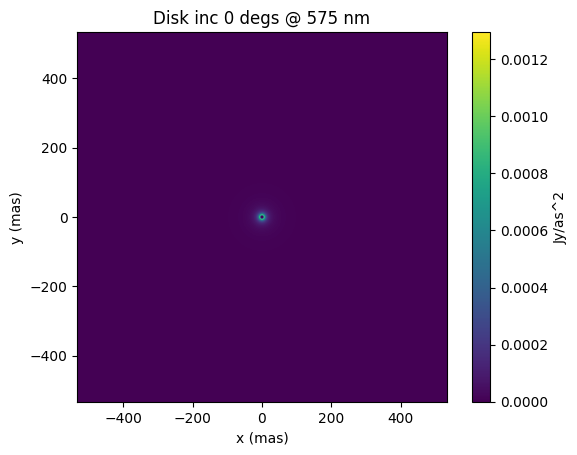

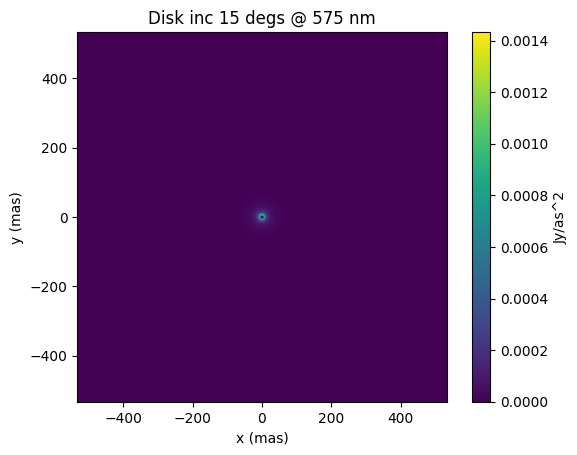

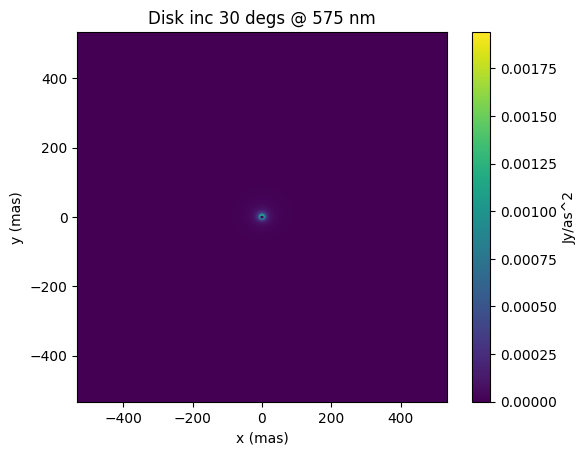

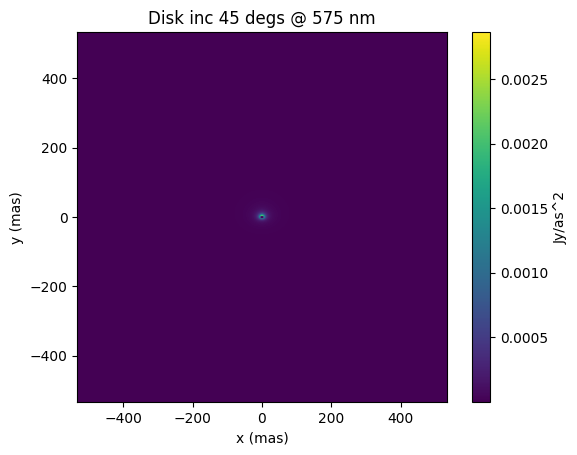

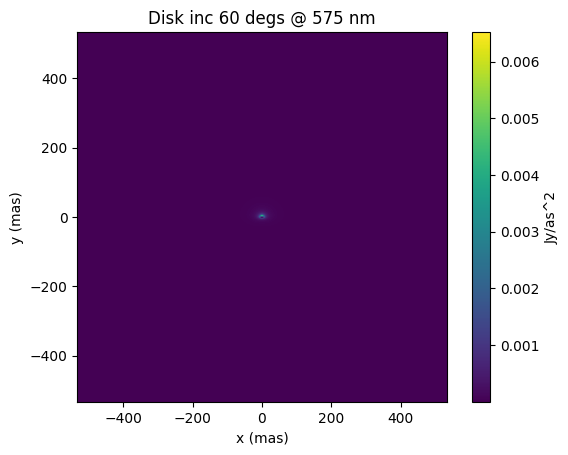

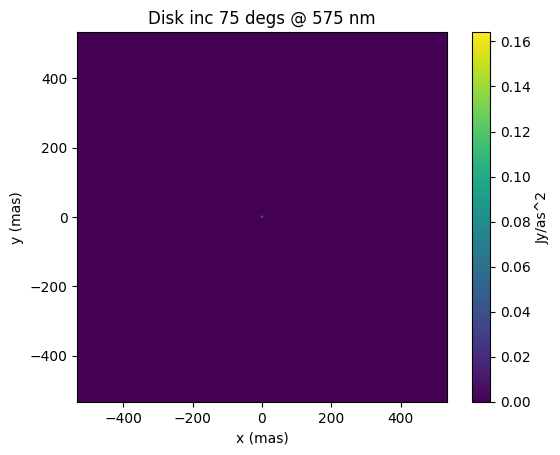

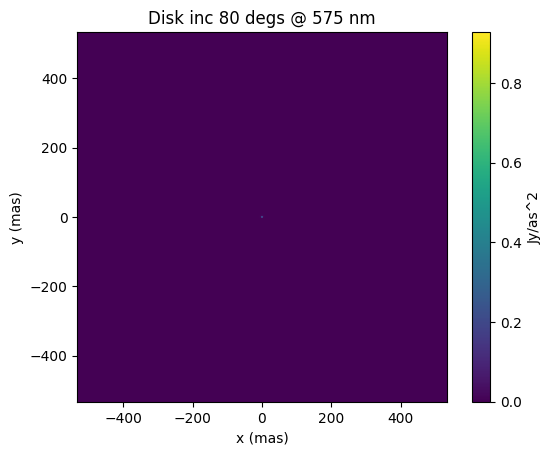

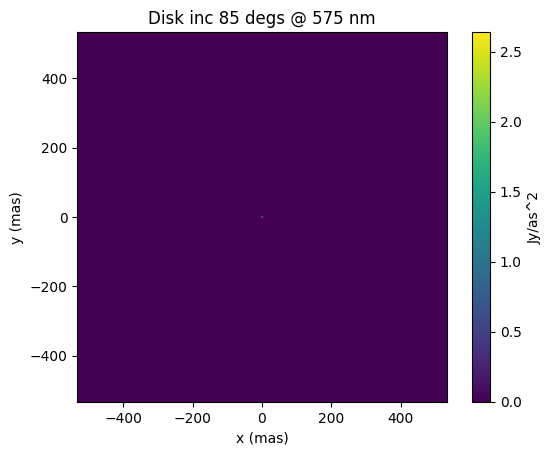

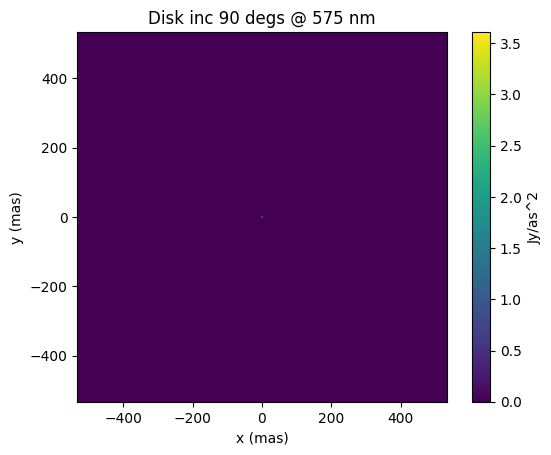

In [ ]:
import astropy.io.fits as fits
import os
import glob
from libmambapy import sign
import numpy as np
import matplotlib.pyplot as plt

# Set the path to the output folder containing the FITS files
output_folder = 'output'

# Get a list of all FITS files in the output folder
fits_files = glob.glob(os.path.join(output_folder, '*.fits'))
# sort the files by the number in the filename
fits_files.sort(key=lambda x: int(x.split('/')[-1].split('-')[0]))

# Choose the desired wavelength (in microns)
desired_wavelength = 0.575  # Example: 1 micron

# Loop through each FITS file
for fits_file in fits_files[::]:
    # Open the FITS file
    with fits.open(fits_file) as hdul:

        # Get the wavelength for the disk contrast cube
        wavelengths = hdul[1].data
        lam_header = hdul[1].header
        '''
        NAXIS1: length of wavelength vector (# of wavelengths)
        SPECRES: spectral resolution of wavelength vector
        LAMMIN: minimum wavelength
        LAMMAX: maximum wavelength
        '''
        lammin = lam_header['LAMMIN']
        lammax = lam_header['LAMMAX']

        # Check if the desired wavelength is within the range of wavelengths in the cube
        if desired_wavelength < lammin or desired_wavelength > lammax:
            print(f'Desired wavelength {desired_wavelength} microns is outside the range of wavelengths in the cube.')
            break

        # Get the disk contrast cube
        disk_cube = hdul[2].data

        # Get header information from Extension 2
        diskheader = hdul[2].header
        '''
        NAXIS1: # of pixels in x dimension
        NAXIS2: # of pixels in y dimension
        NAXIS3: # of wavelengths+1
        SPECRES: spectral resolution of wavelength vector
        PXSCLMAS: pixel scale in milli-arcseconds
        IWA: inner working angle of the coronagraph in arcseconds
        DUSTBLOW: the dust blowout particle size in microns
        TSUB: the dust sublimation temperature in kelvins
        LNGND-N: longitude of the ascending node of the Nth disk component (degrees)
        I-N: inclination of the Nth disk component relative to system midplane (degrees)
        NZODIS-N: density in zodis of the Nth disk component
        R-N: circumstellar distance of the peak density of the Nth disk component (AU)
        DROR-N: value of the normalized Gaussian peak width of the Nth disk component
        RINNER-N: value of the inner truncation radius of the Nth disk component (AU)
        ETA-N: ratio of PR drag time to collision time for the blowout size for the Nth disk component
        HOR-N: normalized scale height for the Nth disk component
        G0-N – G2-N: 3 values of scattering asymmetry parameters for the Nth disk component
        W0-N – W2-N: 3 weights for each HG scattering phase function for the Nth disk component
        MINSIZE: minimum grain size considered
        MAXSIZE: maximum grain size considered
        '''

        # Extract relevant parameters from the header
        pxsclmas = diskheader['PXSCLMAS']  # Pixel scale in milliarcseconds
        iwa = diskheader['IWA']           # Inner working angle in arcseconds
        nxpix = diskheader['NAXIS1']  # Number of pixels in the x dimension
        nypix = diskheader['NAXIS2']  # Number of pixels in the y dimension
        #print(f'Pixel scale: {pxsclmas} mas/pixel')
        #print(f'Inner working angle: {iwa*1000} mas')
        #print(f'Number of pixels in x dimension: {nxpix}')
        #print(f'Number of pixels in y dimension: {nypix}')

        # Get header information from Extension 4
        starheader = hdul[4].header
        '''
        Key header parameters:
        NAXIS1: # of time values
        NAXIS2: # of data values (wavelengths+15) for each time value
        PA: position angle of system midplane (degrees)
        I: inclination of system midplane (degrees)
        STARID: an internal catalog ID # for the star
        RA: right ascension of star (decimal degrees)
        DEC: declination of star (decimal degrees)
        *MAG: stellar empirical magnitude in the * filter band
        M_V: absolute V-band magnitude of star
        DIST: distance to star (pc)
        TYPE: spectral type of star
        LSTAR: bolometric stellar luminosity (solar luminosities)
        TEFF: stellar effective temperature (K)
        ANGDIAM: angular diameter of star (mas)
        MASS: stellar mass (solar masses)
        LOGG: log(stellar gravity) (cm/s2)
        RSTAR: stellar radius (solar radii)
        WDS_SEP: most recent separation of companion in WDS catalog, if it exists (arcsec)
        WDS_DMAG: delta mag of companion in WDS catalog, if it exists
        PMRA: proper motion in RA (mas/yr)
        PMDEC: proper motion in DEC (mas/yr)
        PXSCLMAS: pixel scale (mas)
        '''
        system_inc = int(starheader['I'])   

        # Find the index of the closest wavelength in the cube
        wavelength_index = np.argmin(np.abs(wavelengths - desired_wavelength))
        weight = 1.0
        if wavelengths[wavelength_index] != desired_wavelength:
            wavelength_index_alt = wavelength_index + np.sign(desired_wavelength - wavelengths[wavelength_index]).astype(int)
            weight = np.abs(desired_wavelength - wavelengths[wavelength_index]) / (wavelengths[wavelength_index_alt] - wavelengths[wavelength_index])

        # Extract the 2D contrast map at the desired wavelength
        contrast_map = disk_cube[wavelength_index,:,:]
        if weight != 1.0:
            contrast_map = weight*contrast_map + (1-weight)*disk_cube[wavelength_index_alt,:,:]
        # Calculate the extent for plotting based on pixel scale and IWA
        extent = pxsclmas*np.array([-nxpix/2+0.5, nxpix/2-0.5, -nypix/2+0.5, nypix/2-0.5]) # in milliarcseconds

        # Plot the disk from contrast map and the star flux
        disk_img = contrast_map*steflux(desired_wavelength*1000,lams,bnus)*1e23/(3600*180/np.pi)**2
        
        plt.imshow(disk_img, extent=extent, cmap='viridis', origin='lower')
        plt.colorbar(label='Jy/as^2')
        plt.ylabel('y (mas)')
        
        #plt.plot(np.linspace(extent[0],extent[1],nxpix), disk_img[nxpix//2])
        #plt.ylabel('Jy/as^2')
        plt.title(f'Disk inc {system_inc} degs @ {int(desired_wavelength*1000)} nm')
        plt.xlabel('x (mas)')
        plt.show()
        plt.close()